In [107]:
import tensorflow as tf 
import cv2 
import os 
from collections import Counter
import pandas

In [89]:
rootDir = 'A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles'
vocab = [x for x in "ABCDEFGHIJKLMNOPQRSTUVWXYZ'?!123456789 "]

def getFrameAndSizeCount(path) -> int: 
    cap = cv2.VideoCapture(path)
    frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    size = (width, height)
    cap.release()
    return frameCount, size
def getCharCount(path) -> int: 
    return len(loadText(path))
def numberToWords(num):  
    if num == 0:  
        return "zero"  
    ones = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]  
    tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]  
    teens = ["ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]  
    words = ""  
    if num>= 1000:  
        words += ones[num // 1000] + " thousand "  
        num %= 1000  
    if num>= 100:  
        words += ones[num // 100] + " hundred "  
        num %= 100  
    if num>= 10 and num<= 19:  
        words += teens[num - 10] + " "  
        num = 0  
    elif num>= 20:  
        words += tens[num // 10] + " "  
        num %= 10  
    if num>= 1 and num<= 9:  
        words += ones[num] + " "  
    return words.strip().upper()
def loadText(path): 
    # open and parse the file 
    with open(path, 'r') as file: lines = file.readlines()
    file.close()
    
    # return the number equivalent of each of the characters of the word 
    tokens = []
    words = lines[0].split()
    del words[0]

    for word in words: 
        if word.isnumeric():
            newWord = numberToWords(int(word))
            words[words.index(word)] = newWord
    words = " ".join(words).split()
    
    for word in words: 
        tokens = [*tokens,' ', word]
    
    return charToNum(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]   
charToNum = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

In [94]:
# finding the max number of frames & chars in a certain video 
randomDir = None
def dataStats(dir, progressNum, isDir=True): 
    global randomDir
    frameCt = []
    sizes = []
    charCt = []
    vidList = []
    textList = []
    counter = 0
    if isDir: 
        # iterating through each file in the root folder
        for subdir, dirs, files in os.walk(dir):
            for file in files:
                if file.split('.')[1] == "mp4": 
                    frameCount, size = getFrameAndSizeCount(os.path.join(subdir, file))
                    frameCt.append(frameCount)
                    sizes.append(size)
                    vidList.append(os.path.join(subdir, file))
                    randomDir = (os.path.join(subdir, file))
                if file.split('.')[1] == "txt": 
                    charCt.append(getCharCount(os.path.join(subdir, file)))
                    textList.append(os.path.join(subdir, file))
                counter += 1 
                if counter % progressNum == 0:
                    print(counter, "files done")
    if not isDir: 
        if dir.split('.')[1] == "mp4": 
            frameCount, size = getFrameAndSizeCount(os.path.join(subdir, file))
            frameCt.append(frameCount)
            sizes.append(size)
            vidList.append(os.path.join(subdir, file))
            randomDir = (os.path.join(subdir, file))
        if dir.split('.')[1] == "txt": 
            charCt.append(getCharCount(dir))
            textList.append(dir)
    return frameCt, sizes, charCt, vidList, textList
        

In [134]:
def mostCommon(lst):
    return max(set(lst), key=lst.count)
def freq(lst):
    d = {}
    for i in lst:
        if d.get(i):
            d[i] += 1
        else:
            d[i] = 1
    return d

def printStats(frameCt, sizes, charCt, vidList, textList, percentUsed = 1):    
    print("=" * 100)
    print("=" * 100)

    print("num videos:", len(frameCt))
    print("=" * 100)

    print("FRAME COUNT STATS", '\n')
    print("max frame count:", max(frameCt), ", index:", frameCt.index(max(frameCt)))
    print("longest video:", vidList[frameCt.index(max(frameCt))])
    print("min frame count:", min(frameCt), ", index:", frameCt.index(min(frameCt)))
    print("shortest video:", vidList[frameCt.index(min(frameCt))])
    print("frame count frequencies:", freq(frameCt))
    
    print("=" * 100)
    print("=" * 100)

    print("FRAME SIZE STATS", '\n')
    print("max frame sizes:", max(sizes), ", index:", sizes.index(max(sizes)))
    print("largest (frame size-wise) video:", vidList[sizes.index(max(sizes))])
    print("frame shape frequencies:", freq(sizes))

    print("=" * 100)
    print("=" * 100)

    print("CHAR COUNT STATS", '\n')
    print("max char count:", max(charCt), ", index:", charCt.index(max(charCt)))
    print("longest text:", textList[charCt.index(max(charCt))])
    print("min char count:", min(charCt), ", index:", charCt.index(min(charCt)))
    print("shortest text:", textList[charCt.index(min(charCt))])
    print("char count frequencies:", freq(charCt))
    
    
    print("=" * 100)
    print("=" * 100)    
    print("TOTAL CONTENT STATS", '\n')
    print("total num of frames:", sum(frameCt))
    print("total num of frames used :", int(sum(frameCt) * percentUsed))
    print("total hours of video:", sum(frameCt) / 25 / 3600)
    print("total hours of video used :", int(sum(frameCt) / 25 / 3600) * percentUsed)
    print("=" * 100)
    print("=" * 100)
    print("AVERAGE CONTENT STATS", '\n' )
    print("avg num of frames: ", int(sum(frameCt)/len(frameCt)))
    print("avg chars per vid:", int(sum(charCt)/len(charCt)))
    print("most common number of frames:", mostCommon(frameCt))
    print("most common number of characters:", mostCommon(charCt))
    print("=" * 100)
    print("=" * 100)

def visualizeDistribution(data, name=None):
    data = sorted(data)
    count = Counter(data)
    df = pandas.DataFrame.from_dict(count, orient='index')
    if name is None:
        df.plot(kind='bar', figsize=(25, 5), legend=False)
    else: 
        df.plot(kind='bar', figsize=(25, 5), legend=False, title=name)


In [129]:
frameCt, sizes, charCt, vidList, textList = dataStats("A:\Lip Reading\Potential Datasets\BBC LRS2\\trainFiles6", progressNum=5000)
printStats(frameCt, sizes, charCt, vidList, textList, 0.65)

KeyboardInterrupt: 

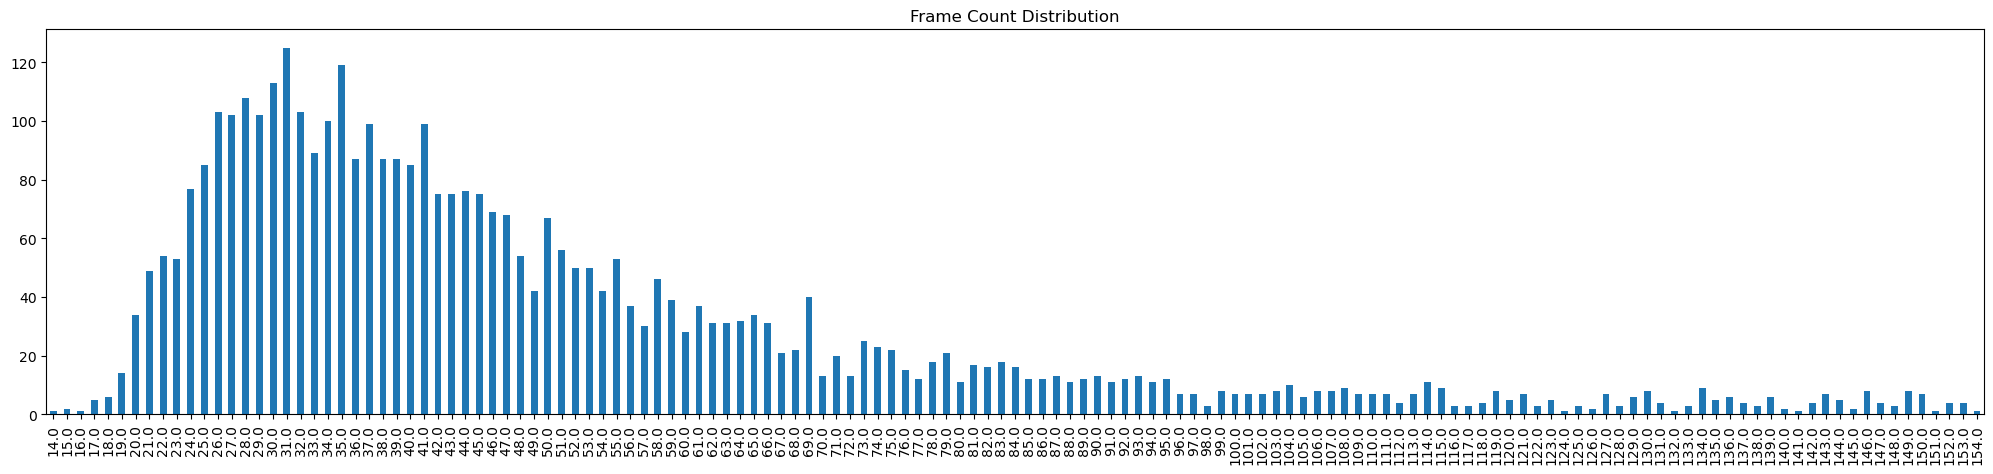

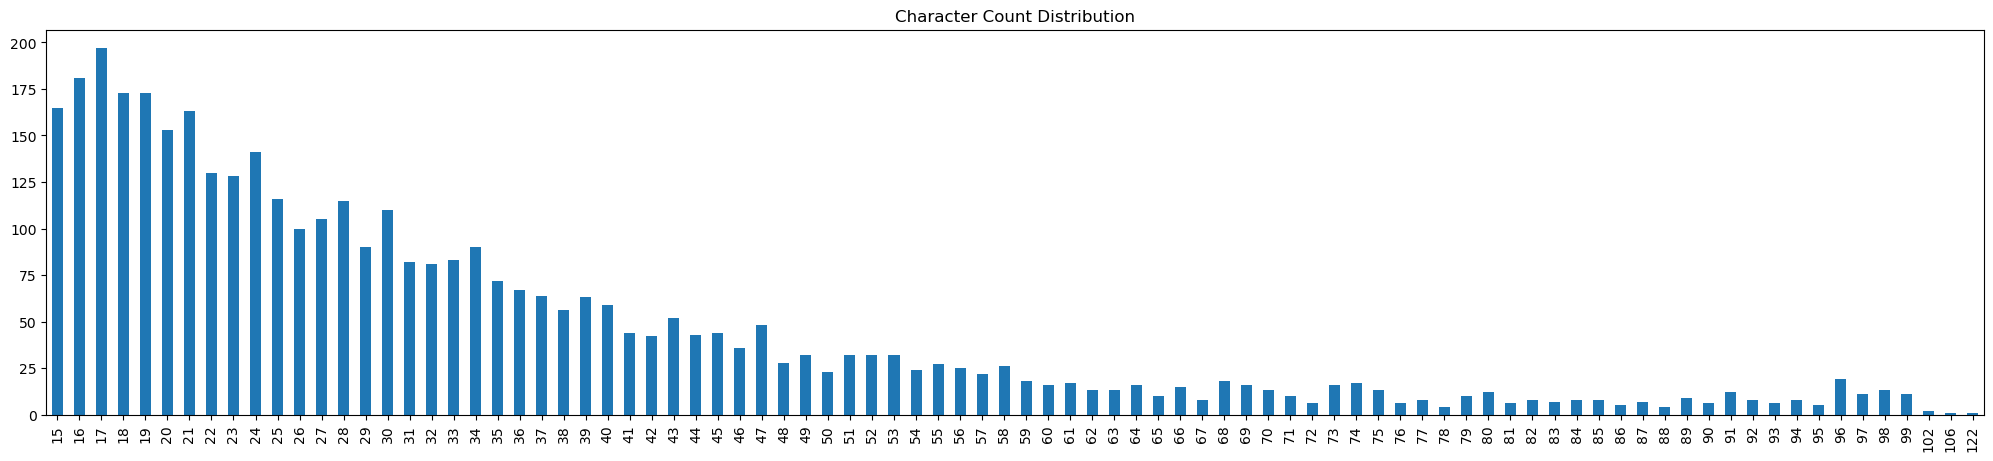

In [135]:
visualizeDistribution(frameCt,"Frame Count Distribution")
visualizeDistribution(charCt, "Character Count Distribution" )

In [45]:
(getFrameCount("A:\v\Lip Reading\\Potential Datasets\\BBC LRS2\\trainFiles\\5536745420943636139_00027.mp4"))

115.0

In [38]:
cap = cv2.VideoCapture(randomDir)
frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
cap.release()
print(frameCount)

0.0


In [44]:
randomDir 

'A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\trainFiles\\6383993433079191521_00008.mp4'